In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, mean, desc,stddev
from pyspark.sql.types import DoubleType, IntegerType, LongType, StringType, DateType
import matplotlib.pyplot as plt
import seaborn as sns

Đề bài này yêu cầu bạn dự đoán sai số log (log-error) giữa giá ước lượng của Zillow (Zestimate) và giá bán thực tế của các căn nhà. Sai số log được định nghĩa là:
logerror= log(Zestimate) − log(SalePrice)

Trong đó:
- Zestimate là giá ước lượng của Zillow.
- SalePrice là giá bán thực tế của căn nhà.


In [2]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("Zillow Competition") \
    .getOrCreate()

24/09/18 04:13:22 WARN Utils: Your hostname, MacBook-Pro-cua-at.local resolves to a loopback address: 127.0.0.1; using 192.168.23.102 instead (on interface en0)
24/09/18 04:13:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/18 04:13:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
properties_2016_df = spark.read.csv('properties_2016.csv', header=True, inferSchema=True)
properties_2017_df = spark.read.csv('properties_2017.csv', header=True, inferSchema=True)
train_2016_df = spark.read.csv('train_2016_v2.csv', header=True, inferSchema=True)
train_2017_df = spark.read.csv('train_2017.csv', header=True, inferSchema=True)

In [4]:
properties_2016_df.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- fireplacecnt: integer (nullable = true)
 |-- fullbathcnt: integer (nullable = true)
 |-- gar

In [5]:
properties_2016_df.count()

2985217

In [6]:
properties_2017_df.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- fireplacecnt: integer (nullable = true)
 |-- fullbathcnt: integer (nullable = true)
 |-- gar

In [7]:
properties_2017_df.count()

2985217

In [8]:
data2016 = train_2016_df.join(properties_2016_df, on='parcelid', how='left')
data2017 = train_2017_df.join(properties_2017_df, on='parcelid', how='left')
print("data2016:", (data2016.count(), len(data2016.columns)))
print("data2017:", (data2017.count(), len(data2017.columns)))

data2016: (90275, 60)


data2017: (77613, 60)


In [9]:
# kết hợp 2 dữ liệu 2017 và 2016
train_with_properties_df = data2016.union(data2017)

In [10]:
train_with_properties_df.printSchema()
train_with_properties_df.show(5)

24/09/18 04:13:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: date (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- firepla

24/09/18 04:13:36 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------+--------+---------------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+----------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|l

In [11]:
# số dòng
train_with_properties_df.count()

167888

In [12]:
# số cột 
len(train_with_properties_df.columns)

60

# Làm sạch 

### Xử lí giá trị thiếu 

In [13]:
# Tính tổng số hàng trong DataFrame
total_rows = train_with_properties_df.count()

# Tính số lượng giá trị thiếu cho mỗi cột
missing_counts_df = train_with_properties_df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in train_with_properties_df.columns]
)

# Tính phần trăm giá trị thiếu cho mỗi cột
missing_percentage_exprs = [
    (count(when(col(c).isNull(), c)) / total_rows * 100).alias(c)
    for c in train_with_properties_df.columns
]
# Tạo DataFrame với phần trăm giá trị thiếu
missing_percentage_df = train_with_properties_df.select(*missing_percentage_exprs)
print(missing_percentage_df.show())

+--------+--------+---------------+---------------------+------------------------+-----------------+--------------------+--------------------+-------------------+---------------------+------------------+-----------------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-----------------+------------------+-----------------+-----------------+-----------------+---------------------+--------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------------+---------------------+------------------+----------------------+------------------+--------------------+--------------------+------------------+--------------------+-----------------+-------------------+----------------------+-----------------+------------------+------------------+------------------+---------

In [14]:
# Chuyển phần trăm giá trị thiếu thành một danh sách các cột để loại bỏ
missing_percentages = missing_percentage_df.collect()[0].asDict()
columns_to_drop = [c for c, pct in missing_percentages.items() if pct >= 60]

print("Các cột cần loại bỏ:", columns_to_drop)

Các cột cần loại bỏ: ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']


In [15]:
# Loại bỏ các cột có giá trị thiếu lớn hơn hoặc bằng 60%
cleaned_df = train_with_properties_df.drop(*columns_to_drop)
cleaned_df.printSchema()
cleaned_df.show(5)
print("Tổng số các cột còn lại là: ",len(cleaned_df.columns))

root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: date (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- fullbathcnt: integer (nullable = true)
 |-- heatingorsystemtypeid: integer (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- lotsizesquarefeet: double (nullable = true)
 |-- propertycountylandusecode: string (nullable = true)
 |-- propertylandusetypeid: integer (nullable = true)
 |-- propertyzoningdesc: string (nullable = true)
 |-- rawcensustractandblock: double (nullable = true)
 |-- regionidcity: integer (nullable = true)
 |-- regionidcounty: integer (nullable = 

+--------+--------+---------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+-----------+---------------------+--------+----------+-----------------+-------------------------+---------------------+------------------+----------------------+------------+--------------+-----------+-------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+
|parcelid|logerror|transactiondate|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fullbathcnt|heatingorsystemtypeid|latitude| longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|unitcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractandblock|
+--------+--

In [16]:
# các cột còn lại 
cleaned_df.columns

['parcelid',
 'logerror',
 'transactiondate',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock']

In [17]:
# tổng số giá trị null còn lại ở 31 cột tương ứng 
null_counts_df = cleaned_df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in cleaned_df.columns]
)
null_counts_df.show()

+--------+--------+---------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+-----------+---------------------+--------+---------+-----------------+-------------------------+---------------------+------------------+----------------------+------------+--------------+-----------+-------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+
|parcelid|logerror|transactiondate|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fullbathcnt|heatingorsystemtypeid|latitude|longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|unitcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractandblock|
+--------+----

In [18]:
# Lấy danh sách các cột số
numerical_columns = [c for c, dtype in cleaned_df.dtypes if dtype in ['int', 'long', 'double', 'float']]

# Tính giá trị trung bình cho mỗi cột số
mean_values_df = cleaned_df.select(
    [mean(col(c)).alias(c) for c in numerical_columns]
)

mean_values = mean_values_df.collect()[0].asDict()
print(mean_values)

{'parcelid': 12995358.543713666, 'logerror': 0.0139063061712419, 'bathroomcnt': 2.2882653973095666, 'bedroomcnt': 3.041738653830114, 'buildingqualitytypeid': 6.015460983643268, 'calculatedbathnbr': 2.312542154453919, 'calculatedfinishedsquarefeet': 1778.630245760276, 'finishedsquarefeet12': 1752.3269391107015, 'fips': 6048.84448389672, 'fullbathcnt': 2.245344943874356, 'heatingorsystemtypeid': 3.924525087315785, 'latitude': 34006777.99591907, 'longitude': -118201116.7705208, 'lotsizesquarefeet': 29510.596012285376, 'propertylandusetypeid': 261.8286189188223, 'rawcensustractandblock': 60491540.44083835, 'regionidcity': 33725.134525060916, 'regionidcounty': 2529.6239231713275, 'regionidzip': 96586.39072176623, 'roomcnt': 1.4774804294208062, 'unitcnt': 1.1103653169014085, 'yearbuilt': 1968.5693109070419, 'structuretaxvaluedollarcnt': 184346.0200407507, 'taxvaluedollarcnt': 472683.32308819675, 'assessmentyear': 2015.462181419567, 'landtaxvaluedollarcnt': 288880.46886226477, 'taxamount': 59

In [19]:
# Điền giá trị trung bình vào các giá trị null

for col_name, mean_value in mean_values.items():
    cleaned_df = cleaned_df.na.fill({col_name: mean_value})
cleaned_df.show(5)

+--------+--------+---------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+-----------+---------------------+--------+----------+-----------------+-------------------------+---------------------+------------------+----------------------+------------+--------------+-----------+-------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+
|parcelid|logerror|transactiondate|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fullbathcnt|heatingorsystemtypeid|latitude| longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|unitcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractandblock|
+--------+--

In [20]:
# Lấy danh sách các cột dạng định tính 
string_columns = [c for c, dtype in cleaned_df.dtypes if dtype == 'string']
# Tạo DataFrame để lưu giá trị phổ biến nhất của mỗi cột string
mode_values = {}
for c in string_columns:
    mode_df = (cleaned_df.groupBy(c)
               .agg(count(c).alias('count'))
               .orderBy(desc('count'))
               .limit(1))
    mode_value = mode_df.collect()[0][0]
    mode_values[c] = mode_value

print("Giá trị phổ biến nhất cho mỗi cột:", mode_values)

24/09/18 04:14:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:14:45 WARN RowBasedKeyValueBatch: Calling spill() on

Giá trị phổ biến nhất cho mỗi cột: {'propertycountylandusecode': '0100', 'propertyzoningdesc': 'LAR1'}


In [21]:
# Điền giá trị phổ biến nhất vào các giá trị null trực tiếp vào cleaned_df
for col_name, mode_value in mode_values.items():
    cleaned_df = cleaned_df.na.fill({col_name: mode_value})

cleaned_df.show(5)

+--------+--------+---------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+-----------+---------------------+--------+----------+-----------------+-------------------------+---------------------+------------------+----------------------+------------+--------------+-----------+-------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+
|parcelid|logerror|transactiondate|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fullbathcnt|heatingorsystemtypeid|latitude| longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|unitcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractandblock|
+--------+--

In [22]:
null_counts_df = cleaned_df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in cleaned_df.columns]
)
null_counts_df.show()

+--------+--------+---------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+-----------+---------------------+--------+---------+-----------------+-------------------------+---------------------+------------------+----------------------+------------+--------------+-----------+-------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+
|parcelid|logerror|transactiondate|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fullbathcnt|heatingorsystemtypeid|latitude|longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|unitcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractandblock|
+--------+----

Sau khi kiểm tra lại giá trị null trong các cột còn hay không thì phát hiện cột "censustractandblock" vẫn chưa được xử lí. => tiến hành xử lí cột này bằng phương pháp điền giá trị trung bình

In [23]:
# Tính giá trị trung bình cho cột censustractandblock
mean_value = cleaned_df.select(mean(col('censustractandblock'))).collect()[0][0]

# Điền giá trị trung bình vào các giá trị null trong cột censustractandblock
cleaned_df = cleaned_df.na.fill({'censustractandblock': mean_value})

# Kiểm tra lại số lượng giá trị null
cleaned_df.filter(col('censustractandblock').isNull()).count()

0

### Xử lí trùng lặp

In [24]:
# Tính số lượng hàng trùng lặp
total_rows = cleaned_df.count()
distinct_rows = cleaned_df.dropDuplicates().count()
duplicate_rows_count = total_rows - distinct_rows

print(f"Số lượng hàng trùng lặp: {duplicate_rows_count}")


24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/18 04:15:10 WARN RowBasedKeyValueBatch: Calling spill() on

Số lượng hàng trùng lặp: 0


# Trực quan hoá 

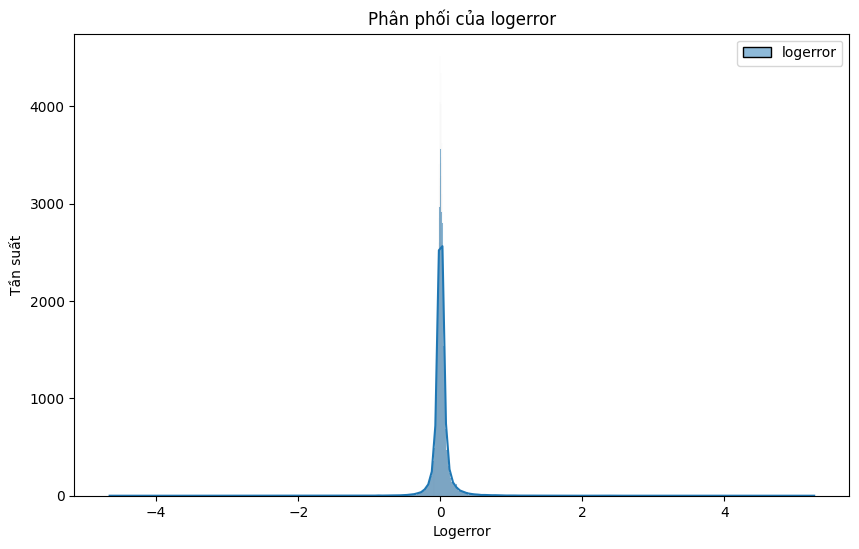

In [25]:
# Tạo biểu đồ phân phối của logerror
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df.select('logerror').toPandas(), kde=True)
plt.title('Phân phối của logerror')
plt.xlabel('Logerror')
plt.ylabel('Tần suất')
plt.show()


Ta thấy phân phối của logerror tương đối đều nhau và cân bằng ở vị trí '0'. Như vậy có vẻ như độ chính xác mô hình này là tương đối tốt. 

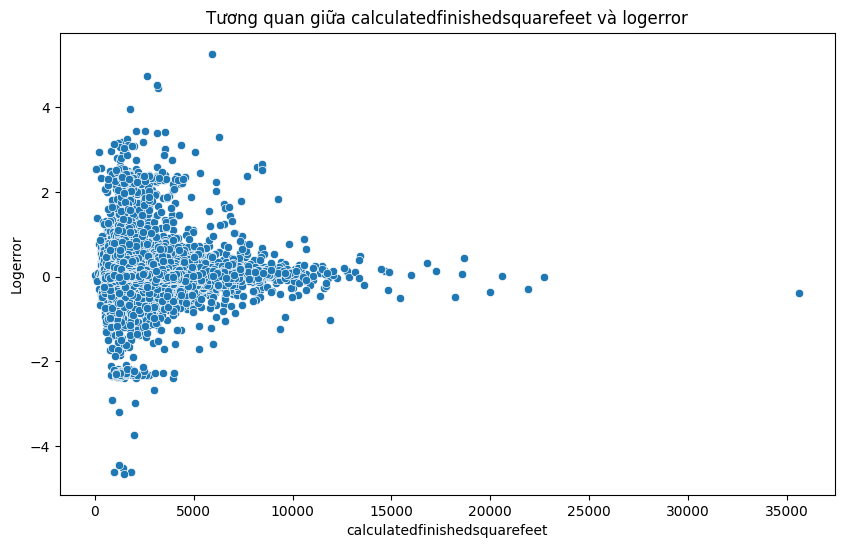

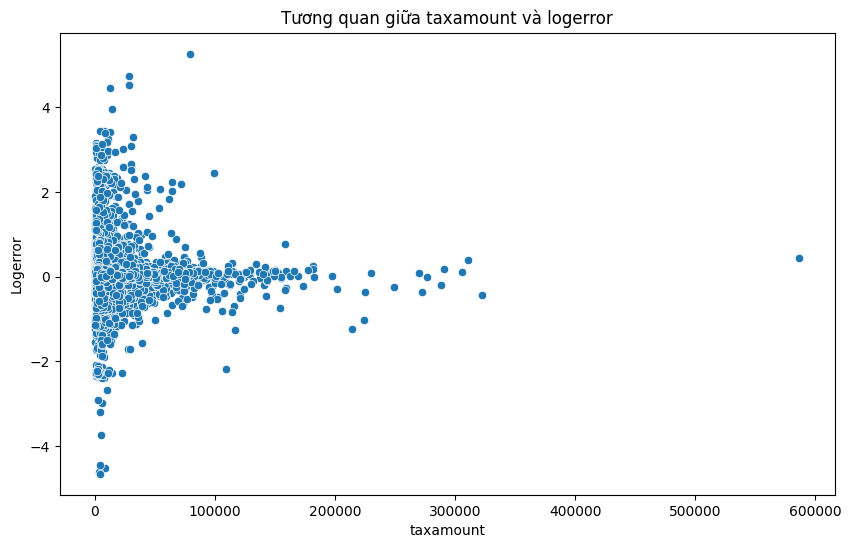

In [26]:
# Biểu Đồ Tương Quan Giữa logerror và Các Biến Số
# Các biến số để kiểm tra (ví dụ, 'calculatedfinishedsquarefeet', 'taxamount')
# calculatedfinishedsquarefeet: Tổng diện tích không gian sống đã hoàn thiện của ngôi nhà 
# taxamount: Tổng số tiền thuế bất động sản đã được định giá cho năm đó.
numeric_columns = ['calculatedfinishedsquarefeet', 'taxamount']

for col_name in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=col_name, y='logerror', data=cleaned_df.toPandas())
    plt.title(f'Tương quan giữa {col_name} và logerror')
    plt.xlabel(col_name)
    plt.ylabel('Logerror')
    plt.show()


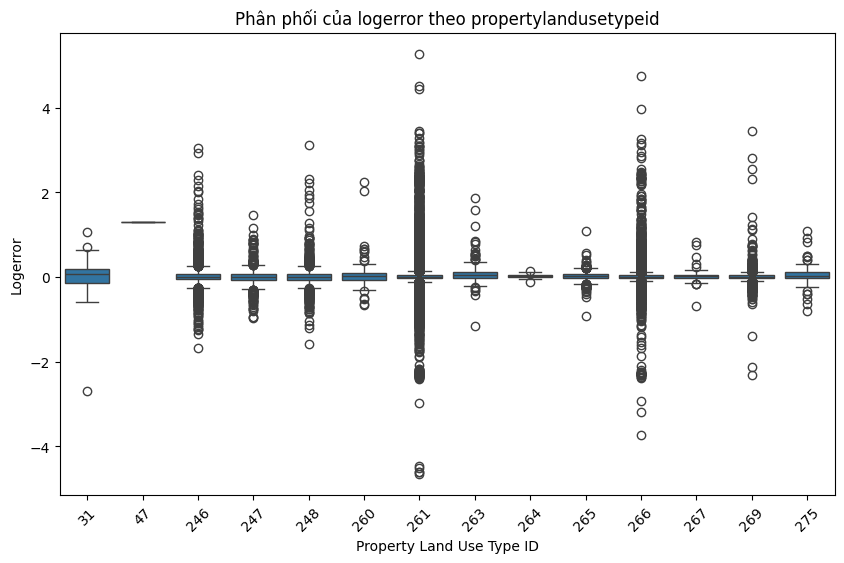

In [27]:
# Chọn cột phân loại để nhóm (ví dụ, 'propertylandusetypeid')
# propertylandusetypeid: Loại sử dụng đất mà bất động sản được phân vùng.
plt.figure(figsize=(10, 6))
sns.boxplot(x='propertylandusetypeid', y='logerror', data=cleaned_df.toPandas())
plt.title('Phân phối của logerror theo propertylandusetypeid')
plt.xlabel('Property Land Use Type ID')
plt.ylabel('Logerror')
plt.xticks(rotation=45)
plt.show()

- Sự khác biệt giữa các loại sử dụng đất: Rõ ràng là có sự khác biệt đáng kể trong phân phối logerror giữa các loại sử dụng đất khác nhau. Điều này cho thấy loại sử dụng đất là một yếu tố quan trọng ảnh hưởng đến độ chính xác của dự đoán giá.
- Giá trị ngoại lệ: Nhiều loại sử dụng đất có các giá trị ngoại lệ, đặc biệt là ở phía trên (logerror dương lớn), cho thấy có một số bất động sản thuộc các loại sử dụng đất này có sai số dự đoán giá rất lớn.

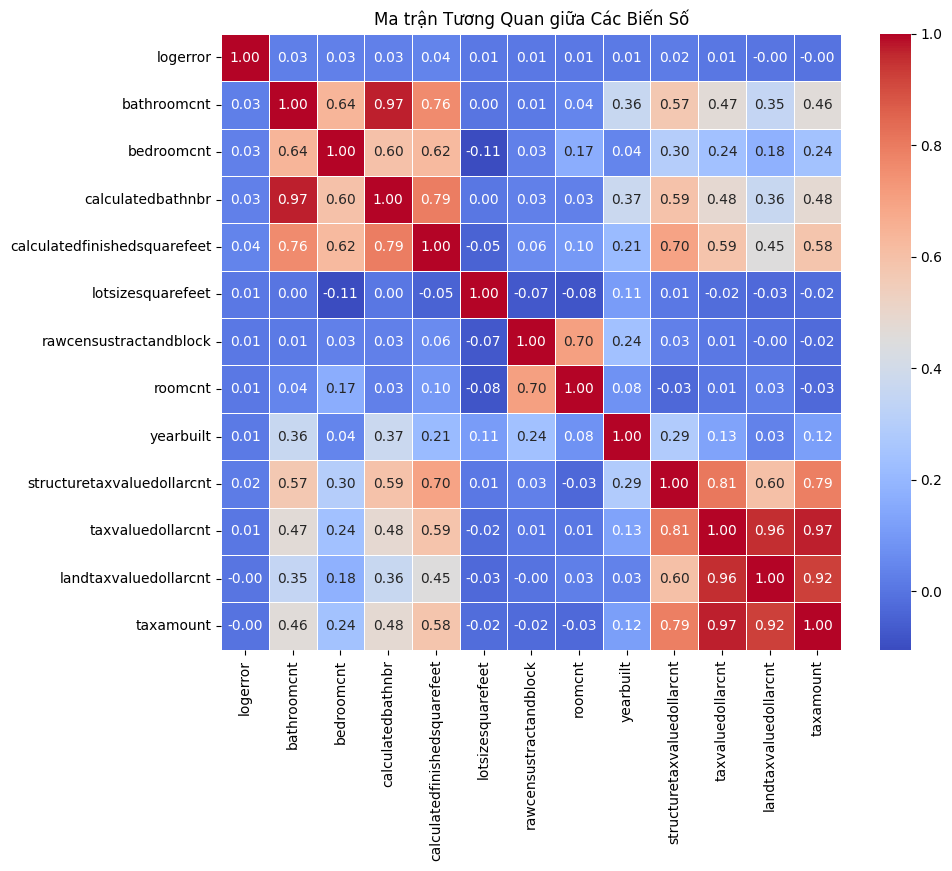

In [28]:
cleaned_pd_df = cleaned_df.toPandas()
# Tính toán ma trận tương quan cho các biến số
correlation_matrix = cleaned_pd_df.select_dtypes(include=['double']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Ma trận Tương Quan giữa Các Biến Số')
plt.show()


# Xử lí ngoại lệ 

In [29]:
# Chuyển đổi cleaned_df sang Pandas DataFrame
logerror_pd_df = cleaned_df.select('logerror').toPandas()

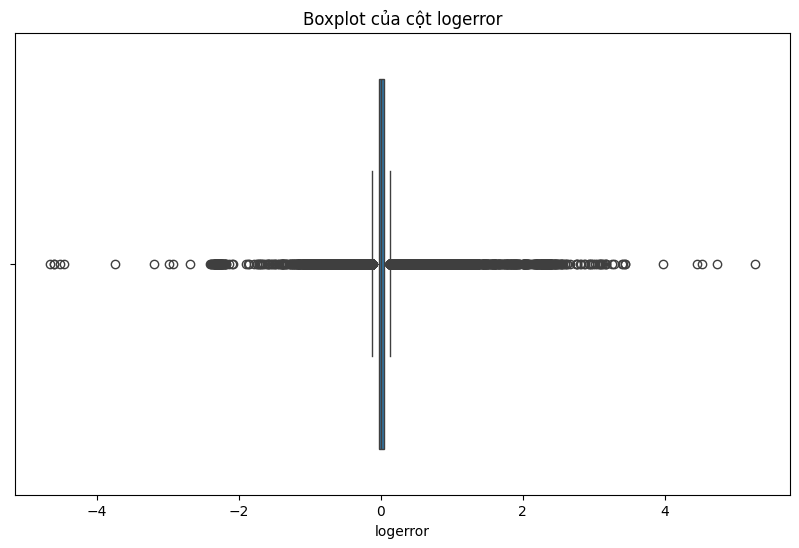

In [30]:
# Vẽ biểu đồ hộp để xem giá trị ngoại lệ
plt.figure(figsize=(10, 6))
sns.boxplot(data=logerror_pd_df, x='logerror')
plt.title('Boxplot của cột logerror')
plt.show()

- Nhiều giá trị ngoại lệ: Có rất nhiều điểm dữ liệu nằm ngoài khoảng biến thiên, đặc biệt ở phía bên phải (giá trị logerror dương cao). Điều này cho thấy mô hình của bạn đang gặp khó khăn trong việc dự đoán chính xác giá nhà của một số ngôi nhà, đặc biệt là những ngôi nhà có giá cao hơn dự kiến.
- Phân phối không đối xứng: Hộp và các đường kẻ vươn ra không đối xứng nhau, cho thấy phân phối của logerror có xu hướng lệch phải. Điều này cũng phù hợp với kết quả phân tích histogram trước đó.
- Trung vị gần 0: Đường kẻ ngang bên trong hộp (trung vị) nằm gần 0, cho thấy mô hình dự đoán khá chính xác.

In [31]:
# Tính mean và stddev của cột 'logerror'
mean_value = cleaned_df.select(mean(col('logerror'))).collect()[0][0]
stddev_value = cleaned_df.select(stddev(col('logerror'))).collect()[0][0]

In [32]:
# Tính Z-Score và thêm cột Z-Score vào dataframe
z_score_df = cleaned_df.withColumn('z_score', (col('logerror') - mean_value) / stddev_value)

In [33]:
# Lọc các giá trị có Z-Score lớn hơn 3 hoặc nhỏ hơn -3
outliers_zscore = z_score_df.filter((col('z_score') > 3) | (col('z_score') < -3))

In [34]:
# Hiển thị số lượng giá trị ngoại lệ
num_outliers_zscore = outliers_zscore.count()
print(f"Số lượng giá trị ngoại lệ dựa trên Z-Score: {num_outliers_zscore}")

Số lượng giá trị ngoại lệ dựa trên Z-Score: 2468


In [35]:
# Hiển thị các giá trị ngoại lệ
outliers_zscore.show()

+--------+--------+---------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+-----------+---------------------+--------+----------+-----------------+-------------------------+---------------------+------------------+----------------------+------------+--------------+-----------+-------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+-------------------+
|parcelid|logerror|transactiondate|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fullbathcnt|heatingorsystemtypeid|latitude| longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|unitcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractan

In [36]:
# Thay thế giá trị ngoại lệ bằng mean của cột logerror
cleaned_df = z_score_df.withColumn(
    'logerror',
    when((col('z_score') > 3) | (col('z_score') < -3), mean_value).otherwise(col('logerror'))
)

# Xóa cột Z-Score sau khi xử lý
cleaned_df = cleaned_df.drop('z_score')


# Chuẩn bị xây mô hình 

In [37]:
from pyspark.sql.functions import year, month, dayofmonth

# trích xuất năm, tháng và ngày từ cột transactiondate
cleaned_df = cleaned_df.withColumn('year', year(cleaned_df['transactiondate']))
cleaned_df = cleaned_df.withColumn('month', month(cleaned_df['transactiondate']))
cleaned_df = cleaned_df.withColumn('day', dayofmonth(cleaned_df['transactiondate']))
cleaned_df = cleaned_df.drop('transactiondate')

In [38]:
# Mã hoá các cột định tính
from pyspark.ml.feature import StringIndexer

In [39]:
# Mã hóa các cột kiểu string
indexers = [
    StringIndexer(inputCol='propertycountylandusecode', outputCol='propertycountylandusecode_index'),
    StringIndexer(inputCol='propertyzoningdesc', outputCol='propertyzoningdesc_index')
]

In [40]:
# Tạo Pipeline để thực hiện mã hóa
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers)
model = pipeline.fit(cleaned_df)
cleaned_df = model.transform(cleaned_df)

In [41]:
# Xóa cột string gốc sau khi mã hóa
cleaned_df = cleaned_df.drop('propertycountylandusecode').drop('propertyzoningdesc')

In [42]:
# Sử dụng VectorAssembler để kết hợp các biến đầu vào thành một cột duy nhất.
# Chọn các cột biến đầu vào (bỏ cột logerror và cột đã được mã hóa)

from pyspark.ml.feature import VectorAssembler
feature_columns = [col for col in cleaned_df.columns if col != 'logerror']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(cleaned_df).select('features', 'logerror')

In [43]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Mô hình 

### Linear Regression

Lựa chọn mô hình hồi quy tuyến tính ( Linear Regression). Bởi vì:
- Đơn Giản và Dễ Hiểu: Mô hình hồi quy tuyến tính rất dễ hiểu và giải thích. Bạn có thể thấy ảnh hưởng của từng biến số đầu vào lên biến mục tiêu một cách rõ ràng.
- Nhanh và Tiết Kiệm Tài Nguyên:Huấn luyện mô hình hồi quy tuyến tính thường rất nhanh và yêu cầu ít tài nguyên tính toán, đặc biệt là so với các mô hình phức tạp hơn.
- Dễ Dàng Triển Khai: Mô hình hồi quy tuyến tính dễ triển khai và có thể áp dụng ngay cả khi bạn chỉ có một lượng dữ liệu nhỏ.



In [48]:
from pyspark.ml.regression import LinearRegression


In [49]:
lr = LinearRegression(featuresCol='features', labelCol='logerror')

In [50]:
# huấn luyện 
lr_model = lr.fit(train_data)

24/09/10 14:03:29 WARN Instrumentation: [72b2047e] regParam is zero, which might cause numerical instability and overfitting.
24/09/10 14:03:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/10 14:03:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/09/10 14:03:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [51]:
# Dự đoán trên tập kiểm tra
predictions = lr_model.transform(test_data)

Đánh giá bằng Mean Absolute Error. Bởi vì:
- Dễ Hiểu và Đơn Giản: MAE đo lường mức độ sai lệch trung bình giữa giá trị dự đoán và giá trị thực tế. Nó là giá trị trung bình của các sai số tuyệt đối và dễ hiểu, dễ giải thích.

- Hợp Lý Với Mục Tiêu Dự Đoán Log-Error:Trong bài toán, mục tiêu là dự đoán log-error, mà là log của tỷ lệ giữa giá ước lượng và giá thực tế. MAE phù hợp cho việc đánh giá mức độ chính xác của dự đoán log-error vì nó cung cấp sự đánh giá trung bình về sai lệch.

In [52]:
# Đánh giá mô hình
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='logerror', predictionCol='prediction', metricName='mae')
mae = evaluator.evaluate(predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.05469280506096706


In [53]:
rmse_evaluator = RegressionEvaluator(labelCol='logerror', predictionCol='prediction', metricName='rmse')
rmse = rmse_evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")


RMSE: 0.08906530738154031


MAE là trung bình của độ lệch tuyệt đối giữa giá trị dự đoán và giá trị thực tế. Với MAE là 0.054, mô hình tương đối đang dự đoán khá chính xác.

 RMSE đo lường sự phân tán của các dự đoán xung quanh giá trị thực tế, với trọng số cao hơn cho các lỗi lớn. RMSE thấp cho thấy mô hình không chỉ dự đoán tốt mà còn có ít sai số lớn.

In [54]:
# Lưu vào tệp hoặc ghi chép
with open('model_results.txt', 'w') as f:
    f.write(f'Initial MAE: {mae}\n')
    f.write(f'Initial RMSE: {rmse}\n')

In [55]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


In [56]:
from pyspark.ml.feature import VectorAssembler

feature_columns = [col for col in cleaned_df.columns if col != 'logerror']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')


In [57]:
lr = LinearRegression(featuresCol='features', labelCol='logerror')


In [58]:
pipeline = Pipeline(stages=[assembler, lr])

In [59]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.001, 0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()


In [60]:
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=RegressionEvaluator(labelCol='logerror'),
                    numFolds=5)


In [61]:
cv_model = cv.fit(cleaned_df)


In [62]:
best_model = cv_model.bestModel

In [63]:
predictions = best_model.transform(cleaned_df)

In [64]:
evaluator_rmse = RegressionEvaluator(labelCol='logerror', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='logerror', predictionCol='prediction', metricName='mae')

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.0886614062096515
MAE: 0.05447062872700445


In [65]:
# Lưu vào tệp hoặc ghi chép
with open('model_results_cross.txt', 'w') as f:
    f.write(f'Initial MAE: {mae}\n')
    f.write(f'Initial RMSE: {rmse}\n')

Giao diện tra cứu kết quả dự đoán log

In [69]:
import tkinter as tk
from tkinter import ttk

In [80]:
def predict_logerror_for_month_year(year, month):
    df_filtered = cleaned_df.filter((col('year') == year) & (col('month') == month))
    predictions_df = best_model.transform(df_filtered)
    mean_predicted_logerror = predictions_df.select(mean(col('prediction'))).collect()[0][0]
    return mean_predicted_logerror

def on_predict():
    try:
        input_year = int(year_entry.get())
        input_month = int(month_entry.get())
        if 1 <= input_month <= 12:
            predicted_logerror = predict_logerror_for_month_year(input_year, input_month)
            result_label.config(text=f'Trung bình logerror dự đoán cho tháng {input_month} năm {input_year}: {predicted_logerror:.4f}')
        else:
            result_label.config(text="Tháng phải nằm trong khoảng từ 1 đến 12.")
    except ValueError:
        result_label.config(text="Vui lòng nhập số hợp lệ cho năm và tháng.")

root = tk.Tk()
root.title("Dự đoán giá trị logerror")

year_label = ttk.Label(root, text="Nhập năm:")
year_label.grid(column=0, row=0, padx=10, pady=10)

year_entry = ttk.Entry(root)
year_entry.grid(column=1, row=0, padx=10, pady=10)

month_label = ttk.Label(root, text="Nhập tháng (1-12):")
month_label.grid(column=0, row=1, padx=10, pady=10)

month_entry = ttk.Entry(root)
month_entry.grid(column=1, row=1, padx=10, pady=10)

predict_button = ttk.Button(root, text="Dự đoán", command=on_predict)
predict_button.grid(column=0, row=2, columnspan=2, pady=10)

result_label = ttk.Label(root, text="")
result_label.grid(column=0, row=3, columnspan=2, pady=10)



In [81]:
root.mainloop()

24/09/10 18:54:41 WARN TransportChannelHandler: Exception in connection from /172.20.10.3:49699
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:340)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:294)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:269)
	at java.base/sun.nio.ch.SocketChannelImpl.implRead(SocketChannelImpl.java:426)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:493)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEven